# Collaborative Filtering Recommender system


## Introduction

In this notebook I'll build Recommender system using SVD (Singular value decomposition)<Br>
    I'll be using [Book-Crossing Dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/) which has BX-Books, BX-Users and BX-Book-Ratings in CSV format<Br>
    I'll only be using BX-Books and BX-Book-Ratings to build Recommender system as BX-Users has User related data which I dont require in this model
    

Steps which are involved in building this Recommender system
* Preprocessing
    * Loading the data and adjusting the error lines in dataset
    * Scraping with BeautifulSoup and Requests to find Missing Authors and Publishing Years
    * Cleaning Text data using Regex
* EDA
    * Plotting Top rated books using Plotly's [Sunburst Chart](https://plot.ly/python/sunburst-charts/)
    * Plotting Books with Highest average rating using [Bar Chart](https://plot.ly/python/bar-charts/)
    * Plotting Count plot of Users who gave more ratings
* Matrix Factorization
    * Using Scipy's SVD and find the missing rating
* Recommender system
    * Building a function that recommends books which are read by other similar users
    * and Finally building a function which plots the images of books as recommendations

### Loading required libraries

In [1]:
import numpy as np
import pandas as pd

#libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as pyo
import plotly.graph_objs as go
pyo.init_notebook_mode(connected = True) #required to view plotly graphs offline

#for preprocessing
from bs4 import BeautifulSoup
import requests
import re

from scipy.sparse.linalg import svds # Matrix Factorization

# to plot images
import cv2
from skimage import io
from matplotlib.font_manager import FontProperties

import warnings
warnings.filterwarnings('ignore')

## Preprocessing

### Loading the data and adjusting the error lines in dataset

BX-Books dataset is a CSV file with separator as ";" , some of the book names has ";" separator within the name due to which those lines get separated more than the default number of columns

    To avoid this we have two options:
   * One is to load dataset with pandas and skip those error lines
   * Or we can load the dataset with additional columns and adjust those error lines, I'll go with the second option

In [2]:
book_df = pd.read_csv('BX-Books.csv',sep=';',error_bad_lines=False,encoding='latin-1')
#error_bad_lines=False - will skip the rows which goes beyond the number of columns
#Python Pandas Error tokenizing data
book_df.head()

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [3]:
df = pd.read_csv('BX-Books.csv',sep=';',names=list(book_df.columns)+'A B C'.split(),encoding='latin-1')
df.isnull().sum()

ISBN                        0
Book-Title                  0
Book-Author                 1
Year-Of-Publication         0
Publisher                   2
Image-URL-S                 0
Image-URL-M                 0
Image-URL-L                 3
A                      271361
B                      271377
C                      271379
dtype: int64

In [4]:
#Error lines
df.fillna({'A':'nan','B':'nan','C':'nan'},inplace=True)
df[(df['A']!='nan')|(df['B']!='nan')|(df['C']!='nan')]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,A,B,C
6451,0735201994,Peterman Rides Again: Adventures Continue with...,"the Catalog Business""",John Peterman,2000,Prentice Hall Art,http://images.amazon.com/images/P/0735201994.0...,http://images.amazon.com/images/P/0735201994.0...,http://images.amazon.com/images/P/0735201994.0...,nan,nan
43666,0330482750,"Three Novels: \A Strange and Sublime Address\""","\""Afternoon Raag\""","\""Freedom Song\""""",Amit Chaudhuri,2001,Pan Macmillan,http://images.amazon.com/images/P/0330482750.0...,http://images.amazon.com/images/P/0330482750.0...,http://images.amazon.com/images/P/0330482750.0...,nan
51750,0413326608,"Upon my word!: More stories from \My word!\"" a...","Tony Shryane""",Frank Muir,1974,Eyre Methuen,http://images.amazon.com/images/P/0413326608.0...,http://images.amazon.com/images/P/0413326608.0...,http://images.amazon.com/images/P/0413326608.0...,nan,nan
92037,0440500702,Schrodinger's Cat Trilogy : \The Universe Next...,"\""The Homing Pigeons\""""",ROBERT A. WILSON,1988,Dell,http://images.amazon.com/images/P/0440500702.0...,http://images.amazon.com/images/P/0440500702.0...,http://images.amazon.com/images/P/0440500702.0...,nan,nan
104318,0373166982,"Please Say \I Do\"" (Three Weddings &amp","A Hurricane) (Harlequin American Romance, No ...",Karen T. Whittenburg,1997,Harlequin,http://images.amazon.com/images/P/0373166982.0...,http://images.amazon.com/images/P/0373166982.0...,http://images.amazon.com/images/P/0373166982.0...,nan,nan
121767,0894805959,The Best of the Journal of Irreproducible Resu...,"Unfounded Findings\""""",George H. Scherr,1989,Workman Publishing,http://images.amazon.com/images/P/0894805959.0...,http://images.amazon.com/images/P/0894805959.0...,http://images.amazon.com/images/P/0894805959.0...,nan,nan
144057,8423920143,"GuÃ­a del lector del \Quijote\"": Ensayo psicol...","14 : Ensayo)""",Salvador de Madariaga,1976,Espasa-Calpe,http://images.amazon.com/images/P/8423920143.0...,http://images.amazon.com/images/P/8423920143.0...,http://images.amazon.com/images/P/8423920143.0...,nan,nan
150788,034050823X,"The Double Detective: \The Blank Page\"" &amp","\""A Fix Like This\"" (Crime Club)""",K.C. Constantine,1990,Hodder &amp; Stoughton General Division,http://images.amazon.com/images/P/034050823X.0...,http://images.amazon.com/images/P/034050823X.0...,http://images.amazon.com/images/P/034050823X.0...,nan,nan
157127,039482492X,"C is for Clown: A Circus of \C\"" Words, (Brigh...","early books for beginning beginners)""",Stan Berenstain,1972,Random House Children's Books,http://images.amazon.com/images/P/039482492X.0...,http://images.amazon.com/images/P/039482492X.0...,http://images.amazon.com/images/P/039482492X.0...,nan,nan
180188,0553570722,"\R\"" for Revenge: Written by Kate William",Created by Francine Pascal (Sweet Valley High...,Francine Pascal,1997,Bantam Books,http://images.amazon.com/images/P/0553570722.0...,http://images.amazon.com/images/P/0553570722.0...,http://images.amazon.com/images/P/0553570722.0...,nan,nan


In [5]:
# filtering rows where data got separated beyond default columns but not exceeding column A
index_list = df[(df['A']!='nan')&(df['B']=='nan')].index.tolist()
# shifting columns back to their original position and storing it in a variable 
adjusted_cols = df.iloc[index_list,1:-2].apply(lambda x:[''.join([x[0],x[1]]),x[2],x[3],x[4],x[5],x[6],x[7],'nan'],axis=1)
# converting the variable to a shape eqivalent to the dataframe and replacing the values in dataframe
df.iloc[index_list,1:-2] = np.array([x for x in adjusted_cols])


# filtering rows where data got separated beyond default columns and A but not exceeding column B
index_list = df[(df['B']!='nan')&(df['C']=='nan')].index.tolist()
adjusted_cols = df.iloc[index_list,1:-1].apply(lambda x:[''.join([x[0],x[1],x[2]]),x[3],x[4],x[5],x[6],x[7],x[8],'nan','nan'],axis=1)
df.iloc[index_list,1:-1] = np.array([x for x in adjusted_cols])


# filtering rows where data got separated beyond A and B but not exceeding column C
index_list = df[(df['C']!='nan')].index.tolist()
adjusted_cols = df.iloc[index_list,1:].apply(lambda x:[''.join([x[0],x[1],x[2],x[3]]),x[4],x[5],x[6],x[7],x[8],x[9],'nan','nan','nan'],axis=1)
df.iloc[index_list,1:] = np.array([x for x in adjusted_cols])

In [6]:
df.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
A                      0
B                      0
C                      0
dtype: int64

These 3 missing values in "Image-URL-L" is because 3 of the rows didn't get separated properly

In [7]:
index_list = df[df['Image-URL-L'].isna()].index.tolist()
adjusted_cols = df.iloc[index_list,1:-3].apply(lambda x:x[0].split(';')+[x[1],x[2],x[3],x[4],x[5]] ,axis=1)
df.iloc[index_list,1:-3] = np.array([x for x in adjusted_cols])
df.iloc[index_list,:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,A,B,C
209551,078946697X,"DK Readers: Creating the X-Men, How It All Beg...","Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,nan,nan,nan
220745,2070426769,"Peuple du ciel, suivi de 'Les Bergers\""","Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,nan,nan,nan
221692,0789466953,"DK Readers: Creating the X-Men, How Comic Book...","James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,nan,nan,nan


Next thing I've noticed is that even though there is only one missing value in "Author" column, There are many "Unknown" values in that column

In [8]:
df[df['Book-Author'].isna()] = df[df['Book-Author'].isna()].fillna('Unknown')
df[df['Book-Author']=='Unknown']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,A,B,C
15248,0380804174,Elizabeth,Unknown,1998,Avon,http://images.amazon.com/images/P/0380804174.0...,http://images.amazon.com/images/P/0380804174.0...,http://images.amazon.com/images/P/0380804174.0...,nan,nan,nan
23868,0671456393,PICK UP STICKS,Unknown,1982,Pocket,http://images.amazon.com/images/P/0671456393.0...,http://images.amazon.com/images/P/0671456393.0...,http://images.amazon.com/images/P/0671456393.0...,nan,nan,nan
44871,0920269028,"Stitch by Stitch: A Home Library of Sewing, Kn...",Unknown,1984,Torstar Books,http://images.amazon.com/images/P/0920269028.0...,http://images.amazon.com/images/P/0920269028.0...,http://images.amazon.com/images/P/0920269028.0...,nan,nan,nan
46515,0134681584,San Francisco (Insight Guide San Francisco),Unknown,1988,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/0134681584.0...,http://images.amazon.com/images/P/0134681584.0...,http://images.amazon.com/images/P/0134681584.0...,nan,nan,nan
59376,0671826859,GHOST STY,Unknown,1980,Pocket,http://images.amazon.com/images/P/0671826859.0...,http://images.amazon.com/images/P/0671826859.0...,http://images.amazon.com/images/P/0671826859.0...,nan,nan,nan
61908,0671836056,NIGHTWAY,Unknown,1981,Pocket,http://images.amazon.com/images/P/0671836056.0...,http://images.amazon.com/images/P/0671836056.0...,http://images.amazon.com/images/P/0671836056.0...,nan,nan,nan
62725,0671451162,NEW TERRORS 1,Unknown,1982,Pocket,http://images.amazon.com/images/P/0671451162.0...,http://images.amazon.com/images/P/0671451162.0...,http://images.amazon.com/images/P/0671451162.0...,nan,nan,nan
65460,0671494260,GENTLE FURY,Unknown,1983,Pocket,http://images.amazon.com/images/P/0671494260.0...,http://images.amazon.com/images/P/0671494260.0...,http://images.amazon.com/images/P/0671494260.0...,nan,nan,nan
76353,0671472321,STAR TRK WRTH KHAN,Unknown,1983,Star Trek,http://images.amazon.com/images/P/0671472321.0...,http://images.amazon.com/images/P/0671472321.0...,http://images.amazon.com/images/P/0671472321.0...,nan,nan,nan
79423,0671444867,BLOOD FEVER,Unknown,1982,Pocket,http://images.amazon.com/images/P/0671444867.0...,http://images.amazon.com/images/P/0671444867.0...,http://images.amazon.com/images/P/0671444867.0...,nan,nan,nan


### Scraping with BeautifulSoup and Requests to find Missing Authors and Publishing Years

In [9]:
# Below function takes ISBN as input and returns Author if it could find the Author or else it returns 'Unknown'

def book_author_parser(ISBN):
    url = 'https://www.abebooks.com/servlet/SearchResults?cm_sp=SearchF-_-topnav-_-Results&kn='+ISBN+'&sts=t'
    response = requests.get(url,headers={'User-Agent': 'Mozilla/5.0'}).text
#     print(response.status_code)
    soup = BeautifulSoup(response)
    search_result = soup.find('div',attrs={'class':'result-set'})
#     print(search_result)
    if search_result is None:
        return 'Unknown'
    else:
        author = search_result.find('p',attrs={'class':'author'})
        if author.text is '':
            author_lst = search_result.find_all('p',attrs={'class':'author'})
            return author_lst[1].text
        else:
            return author.text
        
df['Book-Author'] = df[['ISBN','Book-Author']].apply(lambda x:x[1] if x[1]!='Unknown' else book_author_parser(x[0]),axis=1)
df[df['Book-Author']=='Unknown']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,A,B,C
65460,0671494260,GENTLE FURY,Unknown,1983,Pocket,http://images.amazon.com/images/P/0671494260.0...,http://images.amazon.com/images/P/0671494260.0...,http://images.amazon.com/images/P/0671494260.0...,nan,nan,nan
155809,0671418297,Wnw Vest Pocket D,Unknown,1980,Word Publishing,http://images.amazon.com/images/P/0671418297.0...,http://images.amazon.com/images/P/0671418297.0...,http://images.amazon.com/images/P/0671418297.0...,nan,nan,nan
187701,9627982032,The Credit Suisse Guide to Managing Your Perso...,Unknown,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,nan,nan,nan


In [10]:
# Filling "Null" Values in Publisher column manually

df[df['Publisher'].isna()] = df[df['Publisher'].isna()].fillna('Unknown')
index_list = df[df['Publisher']=='Unknown'].index.tolist()
df.loc[index_list,'Publisher'] = ['Scholastic','NovelBooks, Inc','CreateSpace Independent Publishing']
df.loc[index_list,:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,A,B,C
92682,0590414313,The Magic School Bus on the Ocean Floor (Magic...,Joanna Cole,1994,Scholastic,http://images.amazon.com/images/P/0590414313.0...,http://images.amazon.com/images/P/0590414313.0...,http://images.amazon.com/images/P/0590414313.0...,nan,nan,nan
128897,193169656X,Tyrant Moon,Elaine Corvidae,2002,"NovelBooks, Inc",http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...,nan,nan,nan
129044,1931696993,Finders Keepers,Linnea Sinclair,2001,CreateSpace Independent Publishing,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...,nan,nan,nan


Now replacing 0 values in Year column with scraped data

There are 151 "0" values

In [11]:
df[df['Year-Of-Publication']==0]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,A,B,C
262166,091680013X,Masterpieces of Erotic Photography,David Bailey,0,Harbor House Publishers,http://images.amazon.com/images/P/091680013X.0...,http://images.amazon.com/images/P/091680013X.0...,http://images.amazon.com/images/P/091680013X.0...,nan,nan,nan
262240,190261500X,Ultimate Decorating Book,Judy Spours,0,Kilns House Books,http://images.amazon.com/images/P/190261500X.0...,http://images.amazon.com/images/P/190261500X.0...,http://images.amazon.com/images/P/190261500X.0...,nan,nan,nan
262307,0297826980,Get a Grip On Philosophy,Neil Turnbull,0,Trafalgar Square,http://images.amazon.com/images/P/0297826980.0...,http://images.amazon.com/images/P/0297826980.0...,http://images.amazon.com/images/P/0297826980.0...,nan,nan,nan
262391,0965766950,How to Do Almost Anything the Learn Guide,Jason Roberts,0,Villard Books,http://images.amazon.com/images/P/0965766950.0...,http://images.amazon.com/images/P/0965766950.0...,http://images.amazon.com/images/P/0965766950.0...,nan,nan,nan
262434,1582430012,A Drink Called Paradise,Terese Svoboda,0,Counterpoint Press,http://images.amazon.com/images/P/1582430012.0...,http://images.amazon.com/images/P/1582430012.0...,http://images.amazon.com/images/P/1582430012.0...,nan,nan,nan
262456,0760700362,History of the Middle Ages,Joseph Dahmus,0,Barnes Noble,http://images.amazon.com/images/P/0760700362.0...,http://images.amazon.com/images/P/0760700362.0...,http://images.amazon.com/images/P/0760700362.0...,nan,nan,nan
262469,2070334406,La Sorciere De La Rue Mouffetard,Gripari,0,Livre de Poche,http://images.amazon.com/images/P/2070334406.0...,http://images.amazon.com/images/P/2070334406.0...,http://images.amazon.com/images/P/2070334406.0...,nan,nan,nan
262475,2266073966,Un Hero Tres Discret,Deniau,0,Pocket,http://images.amazon.com/images/P/2266073966.0...,http://images.amazon.com/images/P/2266073966.0...,http://images.amazon.com/images/P/2266073966.0...,nan,nan,nan
262481,0207187320,My Brother Jack,George Johnston,0,Harpercollins Publisher,http://images.amazon.com/images/P/0207187320.0...,http://images.amazon.com/images/P/0207187320.0...,http://images.amazon.com/images/P/0207187320.0...,nan,nan,nan
262491,0441942547,Year of the Unicorn,Andre Norton,0,Penguin Putnam~mass,http://images.amazon.com/images/P/0441942547.0...,http://images.amazon.com/images/P/0441942547.0...,http://images.amazon.com/images/P/0441942547.0...,nan,nan,nan


In [12]:
# Below function takes ISBN as input and returns Year of Publishing if it could find the year or else it returns 'Unknown'
def book_publishing_year(ISBN):
    url = 'https://www.abebooks.com/servlet/SearchResults?cm_sp=SearchF-_-topnav-_-Results&kn='+ISBN+'&sts=t'
    response = requests.get(url,headers={'User-Agent': 'Mozilla/5.0'}).text
    soup = BeautifulSoup(response)
    search_result = soup.find('div',attrs={'class':'result-set'})
    if search_result is None:
        return 'Unknown'
    else:
        year_lst = search_result.find_all('p',attrs={'id':'publisher'})
        if year_lst == []:
            return 'Unknown'
        else:
            year = 'Unknown'
            for lst in year_lst:
                try:
                    year = lst.find_all('span')[1]
                    break
                except IndexError:
                    continue
            return year if year is 'Unknown' else year.text
        
df['Year-Of-Publication'] = df[['ISBN','Year-Of-Publication']].apply(lambda x:str(x[1]) if x[1]!=0 else book_publishing_year(x[0]),axis=1)
df[df['Year-Of-Publication']=='Unknown']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,A,B,C
262629,8804409118,Nuvola Di Smog Formica Argentina,Italo Calvino,Unknown,Oscar Italian,http://images.amazon.com/images/P/8804409118.0...,http://images.amazon.com/images/P/8804409118.0...,http://images.amazon.com/images/P/8804409118.0...,nan,nan,nan
263146,0394854934,Strawberry Shortcake and the berry bears,Valerie Fox,Unknown,Random House,http://images.amazon.com/images/P/0394854934.0...,http://images.amazon.com/images/P/0394854934.0...,http://images.amazon.com/images/P/0394854934.0...,nan,nan,nan
263638,1577341856,Primary Partners Vol. 2: Nursery-Age 3,Mary Ross,Unknown,Covenant Communications,http://images.amazon.com/images/P/1577341856.0...,http://images.amazon.com/images/P/1577341856.0...,http://images.amazon.com/images/P/1577341856.0...,nan,nan,nan
263802,9652236241,"Â°Iyunim bi-Megilat Teman: Kehilat TsanÂ°a, Sh...",Joseph Tobi,Unknown,"HotsaÂ®at sefarim Â°a. sh. Y.L. Magnes, ha-Uni...",http://images.amazon.com/images/P/9652236241.0...,http://images.amazon.com/images/P/9652236241.0...,http://images.amazon.com/images/P/9652236241.0...,nan,nan,nan
263853,0590477358,The Dark-Thirty: Southern Tales of the Superna...,Patricia Mckissack,Unknown,Scholastic Inc,http://images.amazon.com/images/P/0590477358.0...,http://images.amazon.com/images/P/0590477358.0...,http://images.amazon.com/images/P/0590477358.0...,nan,nan,nan
263891,0747531811,Psycho,Robert Bloch,Unknown,Trafalgar Square,http://images.amazon.com/images/P/0747531811.0...,http://images.amazon.com/images/P/0747531811.0...,http://images.amazon.com/images/P/0747531811.0...,nan,nan,nan
264036,0140037896,Night,Edna Obrien,Unknown,Penguin Putnam~trade,http://images.amazon.com/images/P/0140037896.0...,http://images.amazon.com/images/P/0140037896.0...,http://images.amazon.com/images/P/0140037896.0...,nan,nan,nan
264244,0330285513,Sex and Destiny: The Politics of Human Fertility,Germaine Greer,Unknown,Pan Books Ltd,http://images.amazon.com/images/P/0330285513.0...,http://images.amazon.com/images/P/0330285513.0...,http://images.amazon.com/images/P/0330285513.0...,nan,nan,nan
264453,3468352018,Langenscheidts Kurzgrammatik Latein,Leo Stock,Unknown,Langenscheidt+publishers Inc,http://images.amazon.com/images/P/3468352018.0...,http://images.amazon.com/images/P/3468352018.0...,http://images.amazon.com/images/P/3468352018.0...,nan,nan,nan
264717,0590397710,1000 Questions and Answers,John Cooper,Unknown,Scholastic Inc,http://images.amazon.com/images/P/0590397710.0...,http://images.amazon.com/images/P/0590397710.0...,http://images.amazon.com/images/P/0590397710.0...,nan,nan,nan


It seems function was not able to find most of the unknown values, well it depends on whether the website has the details or not though

Since I'll not be needing A,B and C columns anymore, I'll be dropping them

In [13]:
df.drop(index=0,columns=['A','B','C'],inplace=True)
df.reset_index(drop=True,inplace=True)
book_df = df
book_df.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

### Cleaning Text data using Regex 

There are many unwanted symbols in our dataset, including ratings datset which i haven't loaded yet

In [14]:
import re
def text_cleaner(text):
    text = re.sub(r'&amp;?','&',text)
    text = re.sub(r'(&lt;i>)|(&lt;br>)',':',text)
    text = re.sub(r'(\\)|(\")|(&lt;/i>)|(&lt;?)','',text)
    return text

book_df['Book-Title'] = book_df['Book-Title'].apply(text_cleaner)
book_df['Book-Author'] = book_df['Book-Author'].apply(text_cleaner)
book_df['Publisher'] = book_df['Publisher'].apply(text_cleaner)

All of the ISBNs in our dataset are of length 10 but there are few observations where it exceeded 10 due to spaces and special characters

In [15]:
index_list = book_df[book_df.apply(lambda x:len(x['ISBN'])>10 ,axis=1)].index.tolist()
book_df.loc[index_list,'ISBN'] = book_df.loc[index_list,'ISBN'].apply(lambda x:x.strip()[:10])
book_df.loc[index_list,:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
111813,0486404242,War in Kind: And Other Poems (Dover Thrift Edi...,Stephen Crane,1998,Dover Publications,http://images.amazon.com/images/P/0486404242.0...,http://images.amazon.com/images/P/0486404242.0...,http://images.amazon.com/images/P/0486404242.0...
171215,3518365479,"Suhrkamp TaschenbÃ?Â¼cher, Nr.47, Frost",Thomas Bernhard,1972,Suhrkamp,http://images.amazon.com/images/P/3518365479.0...,http://images.amazon.com/images/P/3518365479.0...,http://images.amazon.com/images/P/3518365479.0...
251441,3442248027,Diamond Age. Die Grenzwelt.,Neal Stephenson,2000,Goldmann,http://images.amazon.com/images/P/3442248027.0...,http://images.amazon.com/images/P/3442248027.0...,http://images.amazon.com/images/P/3442248027.0...
251666,0385722206,Balzac and the Little Chinese Seamstress : A N...,DAI SIJIE,2002,Anchor,http://images.amazon.com/images/P/0385722206.0...,http://images.amazon.com/images/P/0385722206.0...,http://images.amazon.com/images/P/0385722206.0...


In [16]:
# Loading Ratings data
rating_df = pd.read_csv('BX-Book-Ratings.csv',sep=';',encoding='latin-1')
print(rating_df.info())
rating_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
User-ID        1149780 non-null int64
ISBN           1149780 non-null object
Book-Rating    1149780 non-null int64
dtypes: int64(2), object(1)
memory usage: 26.3+ MB
None


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Even though there are no null values in the ratings dataset I've noticed that majority of the ratings are 0,<Br>
    So I am assuming that where the rating is zero the user must have read the book or bought the book but didn't rate it, so in my model I'll not be considering those 0 values while building the model.
    
And a lot of cleaning needs to be done on the ISBNs of ratings dataframe<Br>
    Based on the ISBN format from our books datframe I've noticed that ISBNs have a length of 10 and the fist 9 characters are digits but the last character is either a digit or "X" **_(There are some ISBNs in our ratings data which are of length above 10 but they are few and we will be building User-item matrix based on common values from both the dataframes so those values doesn't matter much)_** <Br> 
    So I'll be looking for values other than these and clean them

In [17]:
#below lambda regex matches for Every ISBN other than the ISBN in the format i mentioned above
index_list = rating_df[rating_df.apply(lambda x:False if re.match(r'(^\d{9}(\d|X)$)',x['ISBN']) else True ,axis=1)].index.tolist()

def ISBN_cleaner(x):
    x = x.strip()
    x = x.upper()
    x = re.sub(r'[^0-9X]|X{2,}','',x)
    return x if x!='' else 'Unknown'

rating_df.loc[index_list,'ISBN'] = rating_df.loc[index_list,'ISBN'].apply(ISBN_cleaner)
rating_df.loc[index_list,:].head()

,User-ID,ISBN,Book-Rating
9,276745,342310538,10
40,276762,342662429,0
54,276762,00007X,0
55,276762,3453124715,4
247,276856,20103389,0


In [18]:
unique_books = len(rating_df['ISBN'].unique())
print(f"Total number of unique Books\t: {unique_books}")

unique_users = len(rating_df['User-ID'].unique())
print(f'Total number of unique Users\t: {unique_users}')

x = rating_df.groupby('User-ID').sum()
zero_rated_users = len(x[x['Book-Rating'] == 0])
print(f"Total number of Users who didn't rate\t: {zero_rated_users}")

x = rating_df.groupby('ISBN').sum()
zero_rated_books = len(x[x['Book-Rating'] == 0])
print(f"Total number of Books with no ratings\t: {zero_rated_books}")

highest_rated_book = rating_df[rating_df['Book-Rating']!=0]['ISBN'].value_counts().index[0]
highest_rated_book_rating = rating_df[rating_df['Book-Rating']!=0]['ISBN'].value_counts()[0]
book_title = book_df[book_df['ISBN'] == highest_rated_book]['Book-Title'][408]
print(f"Book with highest number of ratings\t: {book_title} with total ratings of {highest_rated_book_rating}")

highest_rated_user = rating_df[rating_df['Book-Rating']!=0]['User-ID'].value_counts().index[0]
highest_rated_user_rating = rating_df[rating_df['Book-Rating']!=0]['User-ID'].value_counts()[11676]
print(f"User with highest number of ratings\t: UserID-{highest_rated_user} with total ratings of {highest_rated_user_rating}")

Total number of unique Books	: 339612
Total number of unique Users	: 105283
Total number of Users who didn't rate	: 27478
Total number of Books with no ratings	: 154044
Book with highest number of ratings	: The Lovely Bones: A Novel with total ratings of 707
User with highest number of ratings	: UserID-11676 with total ratings of 8524


##### Combining book_df and rating_df dataframes into one dataframe

In [19]:
merged_df = pd.merge(book_df,rating_df,how='inner',on='ISBN')
merged_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400,0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676,8
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385,0


## EDA

### Plotting Top rated books using Plotly's Sunburst Chart

This is an interactive plot, Clicking on each book will give it's individual ratings

This is actually my first time using plotly, the reason i chose plotly is because they have wide variety of plots and all of them are interactive

I've spent a lot of time understanding this plot, basically this plot needs labels and their parents, the parent of root parent should be nill as it is root parent

In [20]:
ISBN_rating = dict(merged_df[merged_df['Book-Rating']!=0]['ISBN'].value_counts()[:10])

parents = ['']
labels = ['Top 10<br>Most rated Books']
ids = ['Top 10<br>Most rated Books']
#ids is same as labels but since 'Rating : ' label is same for every book, plot is unable to tell difference,
#so by adding ids as same as labels but by concatenating book name with rating will let the plot to diffentiate without
#displaying concatenated book names
values = [sum(ISBN_rating.values())]
authors = ['']
years = ['']

temp_df = merged_df[merged_df['Book-Rating'] != 0]
ISBN_rating = dict(temp_df['ISBN'].value_counts()[:10])
ISBN_book = dict(book_df.set_index('ISBN').loc[ISBN_rating.keys(),'Book-Title'])
ISBN_author = dict(book_df.set_index('ISBN').loc[ISBN_rating.keys(),'Book-Author'])
ISBN_year = dict(book_df.set_index('ISBN').loc[ISBN_rating.keys(),'Year-Of-Publication'])

def title_cleaner(x):
    x = x.split(':')[0].split('(')[0]
    x = x.split()
    if len(x)>3:
        return ' '.join([x[i] if i!=2 else x[i]+'<br>' for i in range(len(x))])
    else:
        return ' '.join(x)


for key in ISBN_book.keys():
    parents.append('Top 10<br>Most rated Books') #appending root parent
    labels.append(title_cleaner(ISBN_book[key])) #appending book as label
    ids.append(title_cleaner(ISBN_book[key]))    #appending book as id
    values.append(ISBN_rating[key])              #appending book's total rating as value
    authors.append(f"Author : {ISBN_author[key]}")#appending book's Author
    years.append(f"Year of Publication : {ISBN_year[key]}")#appending book's Year of publication
    
    #loop within for loop which appends book as parent and ratings as labels
    rating_index_list = temp_df[temp_df['ISBN']==key].groupby('Book-Rating').size().index.tolist()
    labels+=[f"Rating : {index}" for index in rating_index_list]
    ids+=[f"{title_cleaner(ISBN_book[key])} - Rating : {index}" for index in rating_index_list]
    
    parents+=[title_cleaner(ISBN_book[key])]*len(rating_index_list)
    #appends book as parent label as many times as length of book's index rating list
    
    rating_value_list = temp_df[temp_df['ISBN']==key].groupby('Book-Rating').size().values.tolist()
    values+=rating_value_list
    #appending empty strings corresponding to ratings
    authors+=['']*len(rating_index_list)
    years+=['']*len(rating_index_list)
    
# print(parents)
# print(labels)
# print(values)

import plotly.offline as pyo
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
pyo.init_notebook_mode(connected = True) 

fig =go.Figure(go.Sunburst(
    branchvalues='total',
    labels=labels,
    values=values,
    ids=ids,
    customdata = authors,
    meta = years,
    parents=parents,
    hovertemplate='<b>%{label} </b> <br> Total Ratings: %{value} <br> %{customdata} <br> %{meta}',
    name='',
    maxdepth=2,
))

fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))

fig.show()

### Plotting Books with Highest average rating using Bar Chart

Dont get confused with the repetitive names in the plot as some of them are Hardcovers and others paperbacks

In [21]:
def highest_avg_rated_books(books=10,height=700):
    value_counts = temp_df['ISBN'].value_counts()
    value_counts_df = temp_df[temp_df.apply(lambda x: value_counts[x['ISBN']]>100 ,axis=1)]
    #Taking books which have rating count greater than 100
    ISBN_mean_dict = dict(value_counts_df.groupby('ISBN').mean()['Book-Rating'])
    ISBN_mean_dict = dict(sorted(ISBN_mean_dict.items(),key=(lambda x: (x[1],x[0])),reverse=True)[:books])
    
    book_list = [title_cleaner(book_df[book_df['ISBN'] == x]['Book-Title'].values[0])+'<br>'+x for x in ISBN_mean_dict.keys()]
    ratings = [round(x,2) for x in ISBN_mean_dict.values()]
    rating_count = [value_counts_df[value_counts_df['ISBN'] == x].groupby('ISBN').size().values[0] for x in ISBN_mean_dict.keys()]
    
    author_year = ["Author : {}<br>Year : {}".format(book_df[book_df['ISBN'] == x]['Book-Author'].values[0],book_df[book_df['ISBN'] == x]['Year-Of-Publication'].values[0]) for x in ISBN_mean_dict.keys()]
    
#     return book_list,ratings,rating_count,ISBN_mean_dict,book_df.set_index('ISBN').loc[ISBN_mean_dict.keys(),:'Year-Of-Publication']
    
    fig = go.Figure()
    fig.add_trace(go.Bar(x = ratings[::-1],
                        y = [f'Book {x}' for x in range(1,books+1)][::-1],
                        orientation = 'h',
                        text = [x.replace('<br>','',1) if len(x.split())>3 else x for x in book_list[::-1]],
                        textfont = dict(color='black',),
                        textposition='inside',
                        customdata = rating_count[::-1],
                        meta = author_year[::-1],
                        name='',
                        marker=dict(color=rating_count[::-1],colorscale='YlGnBu',
                                    line=dict(color=rating_count[::-1],colorscale='YlGnBu_r', width=0.5)
                                   ),
                        hovertemplate = '<b>%{text} </b> <br><br>Avg Rating: %{x}<br>Total Ratings: %{customdata}<br>%{meta}',))
    
    
    fig.update_layout(title = f'Top {books} books with Highest Average rating',
    xaxis={'title':'Average Rating','range':[6,10]},
    yaxis={'title':'Book Title'},
    height = height)
    
    
    
    fig.show()
    
highest_avg_rated_books(books=20,height=1000)

### Plotting Count plot of Users who gave more ratings

In [22]:
def top_users(users=5):
    top_users = temp_df['User-ID'].value_counts().index[:users]
    user_df = temp_df['User-ID'].apply(lambda x:x in top_users) #checks whether the user is in top_users list
    user_df = temp_df[user_df] #taking df of only top users
    groupby = user_df.groupby(['Book-Rating','User-ID']).size().unstack().fillna(0) #making a pivot with rating as index and user as columns
    
    fig = go.Figure()
    x = ['User-'+x for x in groupby.columns.astype(str)]

    for i in groupby.index:
        fig.add_trace(go.Bar(x=x,
                             y=groupby.loc[i,:].values,
                             name = f'Rating {i}'))

    fig.update_layout(
        title="Count plot of User's rating",
        xaxis=dict(title='Users',
                   titlefont_size=12,
                   tickfont_size=10),
        yaxis=dict(title='Rating',
                   titlefont_size=12,
                   tickfont_size=10),
        barmode='group',
        bargap=0.15, # gap between bars of adjacent location coordinates.
        bargroupgap=0.1 # gap between bars of the same location coordinate.
    )
    fig.show()

top_users(users=7)

## Matrix Factorization

A brief introduction to Matrix factorization

Matrix factorization is dividing our input matrix (in our case it is User-Item matrix) into three matrices,<br>
when we multiply these three matrices we get our input matrix,<Br>
These three matrices are:
    
* U - you can think of it as user matrix holding weights of each latent feature of each user, it's like they are defining to which category the user mostly belongs to. If input matrix has a shape of mxn, U has a shape of mxr
* Sigma - It is a diagonal matrix defining the strengths of each latent factors, Sigma has a shape of rxr
* Vt - you can think of it as item matrix holding weights of each latent feature of each item, it's like they are defining to which category the item mostly belongs to. Vt has a shape of rxn

I recommend watching this [Video](https://www.youtube.com/watch?v=P5mlg91as1c&list=PLG5zuWAFUA8jw2C-ihOJ5I5dKppY9rQCN) or this [Article](http://nicolas-hug.com/blog/matrix_facto_2) to understand Matrix factorization

In SVD we can specify the number of latent factors to consider by passing in it as k value<Br>
    Do note that the sigma outputted by svd is a list of values, so we need to convert it into diagonal matrix

In [23]:
#Creating User-Item Matrix

# As I've said before I am excluding zero values assuming that those are rthe cases where users have 
# bought/read the book but didn't rate
print(f'Before Excluding zeroes{merged_df.shape}')
merged_df = merged_df[merged_df['Book-Rating']!=0]
print(f'After Excluding zeroes{merged_df.shape}')

#Taking only books with ratings greater than 50 as i am getting "IndexError"
value_counts_series = merged_df['ISBN'].value_counts()
merged_df = merged_df[merged_df.apply(lambda x: value_counts_series[x['ISBN']]>50 ,axis=1)]
print(merged_df.shape)

pivot = pd.pivot_table(merged_df,index='User-ID',columns='ISBN',values='Book-Rating',fill_value=0,)
pivot.head()

Before Excluding zeroes(1031594, 10)
After Excluding zeroes(384097, 10)
(48613, 10)


ISBN,002542730X,0060096195,006016848X,0060173289,0060175400,0060199652,0060391626,0060392452,0060502258,0060915544,...,1558744630,1558745157,1559029838,1573225517,1573225789,1573227331,1573229326,1573229571,1592400876,1878424319
User-ID,,,,,,,,,,,,,,,,,,,,,
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
U,S,Vt = svds(pivot.values*1.,k=50)
pred = np.dot(U,np.dot(np.diag(S),Vt))
pred = pd.DataFrame(pred,index=pivot.index,columns=pivot.columns)
pred.head()

ISBN,002542730X,0060096195,006016848X,0060173289,0060175400,0060199652,0060391626,0060392452,0060502258,0060915544,...,1558744630,1558745157,1559029838,1573225517,1573225789,1573227331,1573229326,1573229571,1592400876,1878424319
User-ID,,,,,,,,,,,,,,,,,,,,,
9,0.009966,-0.005042,0.017718,0.005394,0.033983,0.033893,0.024826,0.140543,0.003100,0.022361,...,-0.003131,0.006438,0.011919,0.010968,0.022293,0.007010,0.006718,0.013857,0.021666,0.012663
16,0.014842,0.011143,-0.003530,-0.004544,-0.015831,-0.016369,-0.018042,0.076551,-0.040623,0.011705,...,0.000151,-0.013176,0.011079,-0.008979,-0.001106,-0.007278,0.000829,0.008888,-0.002663,-0.005250
26,0.098384,0.053768,0.093886,-0.111022,0.102222,0.085089,-0.156476,-0.301948,-0.462361,0.379575,...,0.069470,-0.122072,0.016747,0.242506,0.374282,0.033471,0.215183,0.049018,0.111716,-0.017603
42,0.017599,-0.012993,0.024394,0.011844,0.028030,0.024023,0.030901,-0.079152,0.014952,-0.020333,...,0.013555,0.042207,0.021070,-0.003449,0.006748,0.008066,0.012113,0.004344,0.004079,0.001739
51,0.006867,0.030556,-0.010412,-0.015851,-0.000652,0.000988,0.002428,-0.075899,-0.058367,0.025270,...,0.006853,-0.005096,0.052043,-0.029824,-0.015561,0.014748,-0.011947,0.048916,-0.005836,0.021973


In [25]:
def check_rating(user,books=10):
    x = pivot.loc[user][:books]
    y = pred.loc[user][:books]
    df = pd.DataFrame({'Book-Title':book_df.set_index('ISBN').loc[x.index,'Book-Title'].values,
                       'Actual-Rating':x.values,
                       'Predicted-Rating':y.values,
                       'Difference':[abs(a-b) for a,b in zip(x.values,y.values)]
                      })
    return df

check_rating(11676,books=15)

,Book-Title,Actual-Rating,Predicted-Rating,Difference
0,Politically Correct Bedtime Stories: Modern Ta...,6,5.574188,0.425812
1,The Boy Next Door,0,1.267606,1.267606
2,"Men Are from Mars, Women Are from Venus: A Pra...",9,6.719288,2.280712
3,Divine Secrets of the Ya-Ya Sisterhood : A Novel,0,1.221884,1.221884
4,The Poisonwood Bible,10,8.930425,1.069575
5,Prodigal Summer,10,8.022324,1.977676
6,I Know This Much Is True (Oprah's Book Club),10,8.022922,1.977078
7,Stupid White Men ...and Other Sorry Excuses fo...,0,4.376846,4.376846
8,The Divine Secrets of the Ya-Ya Sisterhood: A ...,8,9.411495,1.411495
9,The Bean Trees,0,2.655763,2.655763


## Recommender system
### Building a function that recommends books which are read by other similar users

In [26]:
def recommend(user,recommendations=10,return_df=False):
    actual_ratings = pivot.loc[user,:]
    predicted_ratings = pred.loc[user,:]
    to_recommend = predicted_ratings[actual_ratings == 0].sort_values(ascending=False)[:recommendations]
    
    if return_df:
        return book_df.set_index('ISBN').loc[to_recommend.index,['Book-Title','Book-Author', 'Year-Of-Publication', 'Publisher']]
    else:
        return book_df.set_index('ISBN').loc[to_recommend.index,'Book-Title'].values

In [27]:
recommend(11676)

array(['Dance upon the Air (Three Sisters Island Trilogy)',
       'Stupid White Men ...and Other Sorry Excuses for the State of the Nation!',
       'Little Altars Everywhere: A Novel', 'The Dark Half',
       'Girl, Interrupted',
       'Harry Potter and the Prisoner of Azkaban (Book 3)',
       'Tears of the Moon (Irish Trilogy)',
       "A Child Called It: One Child's Courage to Survive",
       'Roses Are Red (Alex Cross Novels)', 'Dolores Claiborne'],
      dtype=object)

In [28]:
recommend(11676,return_df=True)

,Book-Title,Book-Author,Year-Of-Publication,Publisher
ISBN,,,,
0515131229,Dance upon the Air (Three Sisters Island Trilogy),Nora Roberts,2003,Jove Books
0060392452,Stupid White Men ...and Other Sorry Excuses fo...,Michael Moore,2002,Regan Books
0060976845,Little Altars Everywhere: A Novel,Rebecca Wells,1996,Perennial
0451167317,The Dark Half,Stephen King,1994,Signet Book
0679746048,"Girl, Interrupted",SUSANNA KAYSEN,1994,Vintage
0439136350,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,1999,Scholastic
0515128546,Tears of the Moon (Irish Trilogy),Nora Roberts,2000,Jove Books
1558743669,A Child Called It: One Child's Courage to Survive,Dave Pelzer,1995,Health Communications
0446605484,Roses Are Red (Alex Cross Novels),James Patterson,2001,Warner Vision


### Building a function which plots the images of books as recommendations

I wanted to make use of those Image Url columns :)

In [29]:
def Get_recommendation(user,recommendations=5,color_codes = ['#2A363B','#E84A5F']):
    '''
    user : User-ID
    recommendations : Number of recommendations (int should be greater than or equal to 2)
    color_codes : color of heading and details tab in plot
    '''
    cc = color_codes
    
    
    
    if user in pivot.index:
        
        actual_ratings = pivot.loc[user,:]
        predicted_ratings = pred.loc[user,:]
        to_recommend = predicted_ratings[actual_ratings == 0].sort_values(ascending=False)[:recommendations]
        values = book_df.set_index('ISBN').loc[to_recommend.index,:].values
        
        rows = recommendations
        cols = 2
        fig, axs = plt.subplots(nrows=rows, ncols= cols, figsize=(10,4*rows))
        
        for i in range(rows):
            for j in range(cols):
                if j == 0:
                    try:
                        subs = axs[i,j]
                        subs.axis('off')
                        subs.imshow(cv2.cvtColor(io.imread(values[i,6]), cv2.COLOR_BGR2RGB))
                    except OSError:
                        subs = axs[i,j]
                        subs.axis('off')
                        subs.imshow(cv2.cvtColor(io.imread('image-not-found2.png'), cv2.COLOR_BGR2RGB))
                elif j > 0:
                    subs = axs[i,j]
                    subs.axis('off')
                    bbox1 = dict(boxstyle="square,pad=0.7", fc=cc[0], ec="0.9", alpha=1.0)
                    bbox2 = dict(boxstyle="square,pad=0.7", fc=cc[1], ec="0.9", alpha=1.0)
                    subs.text(0.0,0.8,f'{i+1}. {values[i,0]}',c = 'w',size = 17, ha = 'left', va = 'center',bbox=bbox1)
                    subs.text(0.0,0.5,f'Author : {values[i,1]}\nYear Of Publication : {values[i,2]}\nPublisher : {values[i,3]}',
                              c = 'w',size = 14, ha = 'left', va = 'center',bbox=bbox2)
    else:
        return 'Sorry!! wrong user'

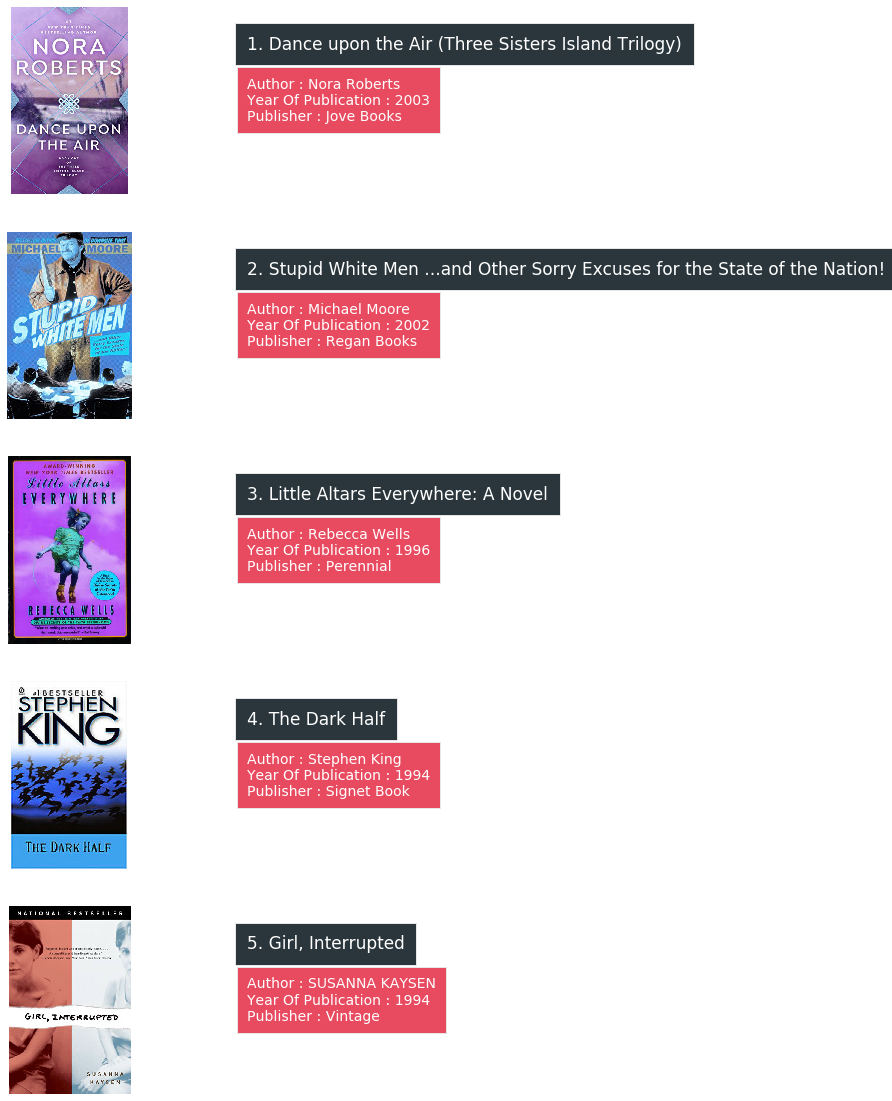

In [30]:
Get_recommendation(11676)

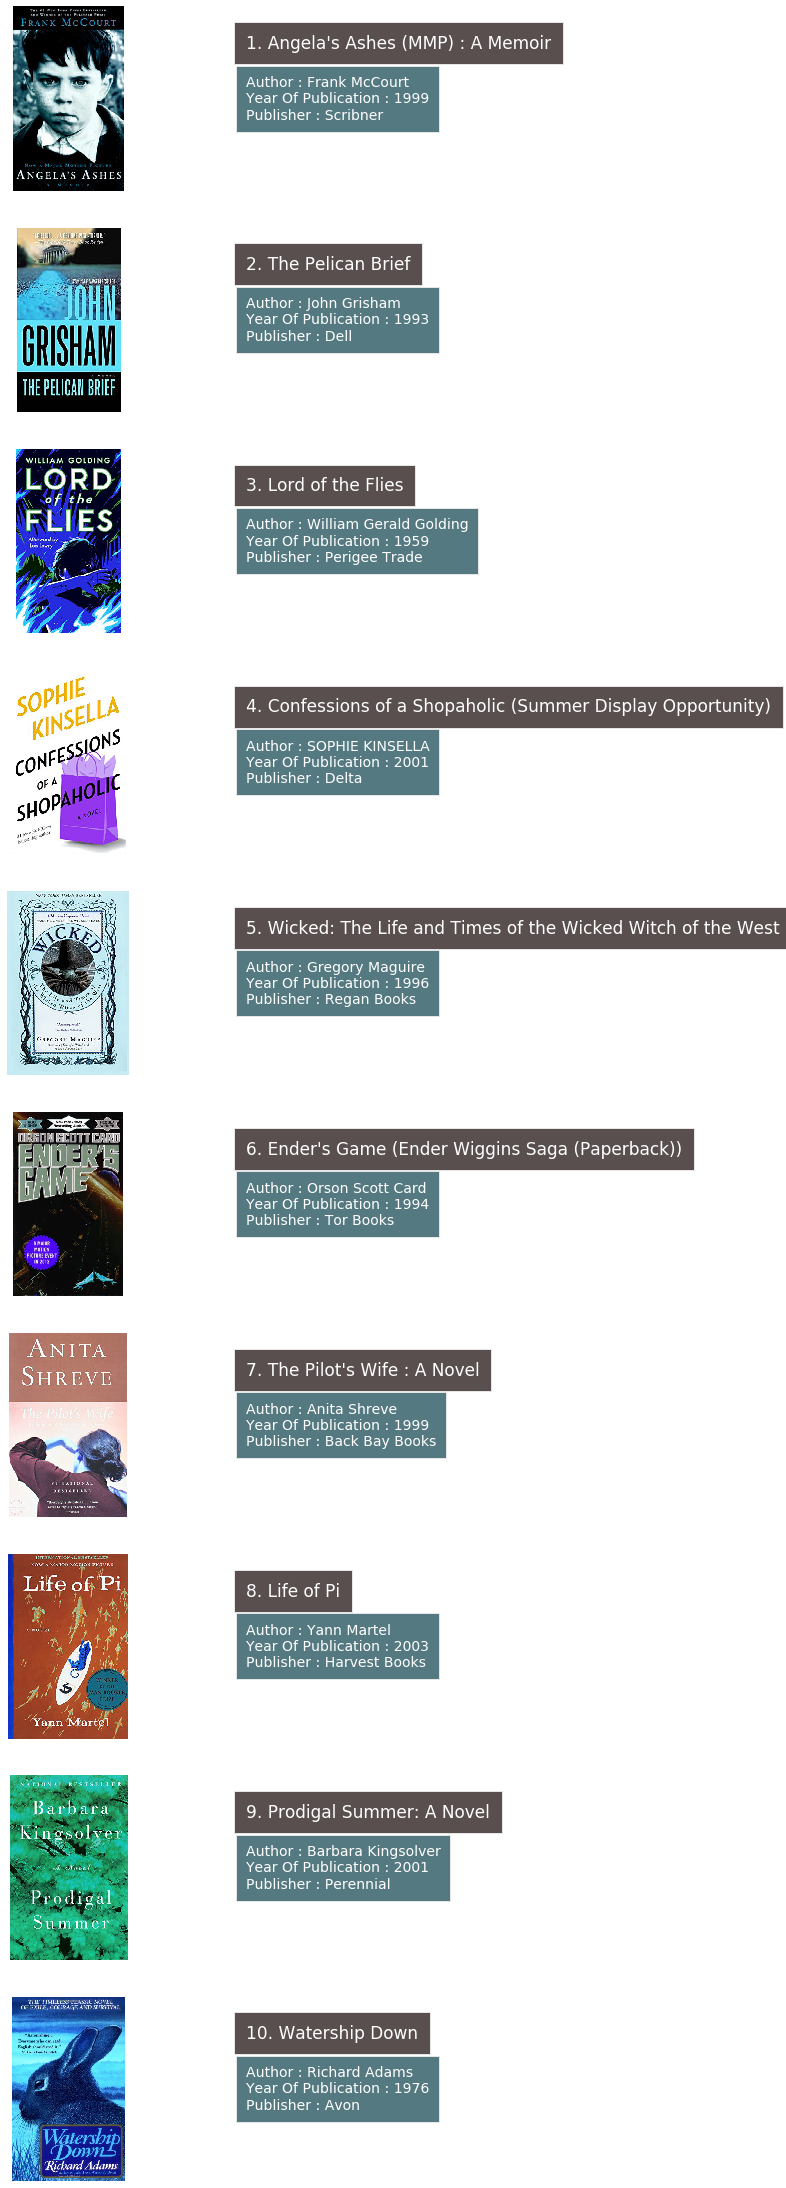

In [31]:
Get_recommendation(23902,recommendations=10,color_codes=['#594F4F', '#547980'])